Deep Learning
=============

Assignment 5_2Byte
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data. Two byte combination embeddings will be generated.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time
import itertools
import string

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string. Words in the string are separated by a space only.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0]))
    #print(data[0:500])
    data = " ".join(data.split())
    print("Number of files in the zip:", len(f.namelist()))
  return data
  
texts = read_data(filename)
print('Data size %d\n' % len(texts))
print(texts[0:500])

Number of files in the zip: 1
Data size 99999999

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosop


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 27*27-1

def build_dataset(text):
    x = itertools.product(string.ascii_lowercase+' ', repeat=2)  # All two char combinations of lowercase letters and space, such as 'AX', ' F'
    dictionary = dict()
    for p in x:
        AStr="".join(p)
        if (AStr != "  "):
            dictionary[AStr] = len(dictionary)
    
    data = list()  # data shall be the text expressed with the unique value assigned above (index value below)
    for i in range(0,len(text)-1,2):
        data.append(dictionary[text[i:i+2]])
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, dictionary, reverse_dictionary

data, dictionary, reverse_dictionary = build_dataset(texts)

print(len(data))
print(data[:100])
print()
print("len(dictionary)=\t", len(dictionary))
print("dic['fg'']=\t\t", dictionary["fg"])
print("reverse_dictionary[8]=\t", reverse_dictionary[8])


49999999
[13, 17, 61, 234, 350, 395, 222, 229, 19, 111, 702, 512, 26, 517, 471, 716, 161, 1, 558, 134, 143, 477, 539, 558, 111, 702, 162, 229, 505, 706, 17, 321, 724, 395, 278, 357, 704, 297, 504, 719, 3, 218, 11, 512, 229, 65, 543, 229, 188, 520, 134, 89, 168, 125, 512, 383, 721, 193, 706, 357, 305, 493, 719, 129, 389, 559, 230, 377, 13, 107, 520, 134, 486, 369, 704, 551, 397, 517, 512, 383, 721, 193, 707, 463, 353, 215, 463, 581, 317, 521, 391, 724, 197, 315, 539, 520, 134, 517, 471, 710]

len(dictionary)=	 728
dic['fg'']=		 141
reverse_dictionary[8]=	 ai


Function to generate a training batch for the skip-gram model.

In skip-gram model, distributed representation of the input word is used to predict the context (words that surrond the input word).

generate_batch() function below returns batch and lables based on the following inputs:
* data, and data_index : global text and index to the text
* batch_size: Learning batch size of stochastic gradient descent training
* num_skips: How many times to reuse an input to generate a label. In other words, how many blocks the batch_size input data should be divided into. batch_size % num_skips must be 0 
* skip_window: How many words to consider left and right. In other words, number of wrods that are to be predicted on each side of the input word.

I think **num_skip should be double of skip_window** in order to generate labels around input word.

generate_batch() function outputs:
* batch: input data for stochastic gradient descent training. It is divided into batch_size/num_skips blocks each of which has a size of 2*skip_window. Each block contains the input word which is the middle of a span in text (span size is 2 * skip_window + 1, [ skip_window target skip_window ])
* labels: words that are to be predicted by the input word. It is also divided into batch_size/num_skips blocks each of which has a size of 2*skip_window. Each block contains randomly ordered words that surround the input word.


In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  for ll in range(batch_size): 
    batch[ll] = 0 
    labels[ll,0] = 0
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # list-like container with fast appends and pops on either end
  # 'buffer' contains continous block 'data' text. Size is 2*skip_window+1 # [ skip_window target skip_window ]   
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  #print('\nbuffer: ', [reverse_dictionary[bb] for bb in buffer])
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    #print('target: ', target)
    #print('targets_to_avoid: ', targets_to_avoid)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # Find a random number which is not in targets_to_avoid
      targets_to_avoid.append(target)
      #print('targets_to_avoid 2: ', targets_to_avoid)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
      #print('    batch:', [reverse_dictionary[bbb] for bbb in batch])
      #print('    labels:', [reverse_dictionary[lll] for lll in labels.reshape(8)])
    buffer.append(data[data_index])  # Next text is psushed to buffer but the first one is moved out. 
    #print('\nbuffer: ', [reverse_dictionary[bb] for bb in buffer])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('    batch:', [reverse_dictionary[br1] for br1 in batch])
    print('    labels:', [reverse_dictionary[br2] for br2 in labels.reshape(8)])

data: ['an', 'ar', 'ch', 'is', 'm ', 'or', 'ig', 'in']

with num_skips = 2 and skip_window = 1:
    batch: ['ar', 'ar', 'ch', 'ch', 'is', 'is', 'm ', 'm ']
    labels: ['an', 'ch', 'is', 'ar', 'm ', 'ch', 'is', 'or']

with num_skips = 4 and skip_window = 2:
    batch: ['ch', 'ch', 'ch', 'ch', 'is', 'is', 'is', 'is']
    labels: ['m ', 'an', 'ar', 'is', 'ar', 'm ', 'ch', 'or']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 27 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # embedding_lookup() function retrieves rows of the params tensor. 
  # The behavior is similar to using indexing with arrays in numpy.
  # Thus result of embedding_lookup() is a dimension (batch_size, embedding_size) tensor in this call.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, 
                               labels=train_labels, inputs=embed, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 50001
start_time = time.time()
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f Time elapsed:%.1f' % (step, average_loss, time.time()-start_time))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        # argsort() returns the indices that would sort an array.
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
print('\n')
#print("embedding shape:\t", final_embeddings.type())
print("embedding shape:\t", final_embeddings.shape)
print("valid_embeddings shape:\t", valid_embeddings.shape)
print("sim shape:\t\t", sim.shape)

print("Time it takes to run the graph with %d:" % num_steps, time.time()-start_time)

Initialized
Average loss at step 0: 3.631708 Time elapsed:0.7
Nearest to br: jm, lv, bq, vu, dy, gu, bk, mo,
Nearest to dp: tl, ng, yf, ge, uu, jg, tn, yv,
Nearest to ao:  x, lf, uq, dj, ir, tc, lr, ca,
Nearest to bh: dt, qg, tj, rv, vj, kc, gd, rt,
Nearest to cr: dh, vt, yp, rq, ld, it, bx, uh,
Nearest to do: ui, zj, xr, sq, gz, gj, lq, rd,
Nearest to by: yv, a ,  z, la, at, si, hp, ml,
Nearest to cl: tr, kx, tn, eg, cy, yg, c , vt,
Nearest to co: v , sx, rx, xu, bs, iu,  t, io,
Nearest to ca: as, fw, jv, pl, ed, fb,  u, ey,
Nearest to cj: xz, zb, uc, gb, zq, gz, ck, ep,
Nearest to cn: ke, nw, uy, dc, d , ud, at, mv,
Nearest to df: mf,  e, yq, pd,  b, il, kq, yl,
Nearest to ab: zh, du, jr, op, by, ff, vq, ig,
Nearest to bo: p , sa, gx, pp, xz, zw, vs, hg,
Nearest to aa: ki, zf, ee, pv, xe, xz, po, rs,
Average loss at step 2000: 2.010590 Time elapsed:3.6
Average loss at step 4000: 1.774793 Time elapsed:6.2
Average loss at step 6000: 1.735612 Time elapsed:8.9
Average loss at step 8000: 

Now save the embeddings for use in other projects. TF has variable saving and restoring service with tf.train.Saver class. But I prefer python pickle in this case. 

In [8]:
import pickle

f = open('TwoCharEmbedding.pckl', 'wb')
pickle.dump([final_embeddings, dictionary, reverse_dictionary, texts], f)
f.close()


In [9]:
num_points = vocabulary_size

# t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between 
# data points to joint probabilities and tries to minimize the Kullback-Leibler divergence 
# between the joint probabilities of the low-dimensional embedding and the high-dimensional data.
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[0:num_points, :])

print("final_embeddings:\t", type(final_embeddings))
print("two_d_embeddings:\t", two_d_embeddings.shape)

print('final_embeddings[32]:\t%s\n' % reverse_dictionary[32], final_embeddings[32, :])

final_embeddings:	 <class 'numpy.ndarray'>
two_d_embeddings:	 (728, 2)
final_embeddings[32]:	bf
 [ 0.2297595   0.11604198 -0.16186151  0.07841912 -0.27451089  0.01861068
 -0.20724232  0.0593353   0.2803089  -0.10459089 -0.2438134   0.29193261
 -0.36407951  0.16633166  0.13451004 -0.07307564  0.16797698  0.32035738
 -0.31689703  0.08712179  0.14797479 -0.05835203  0.13006845 -0.04253782
 -0.22647974 -0.07452152 -0.14715371]


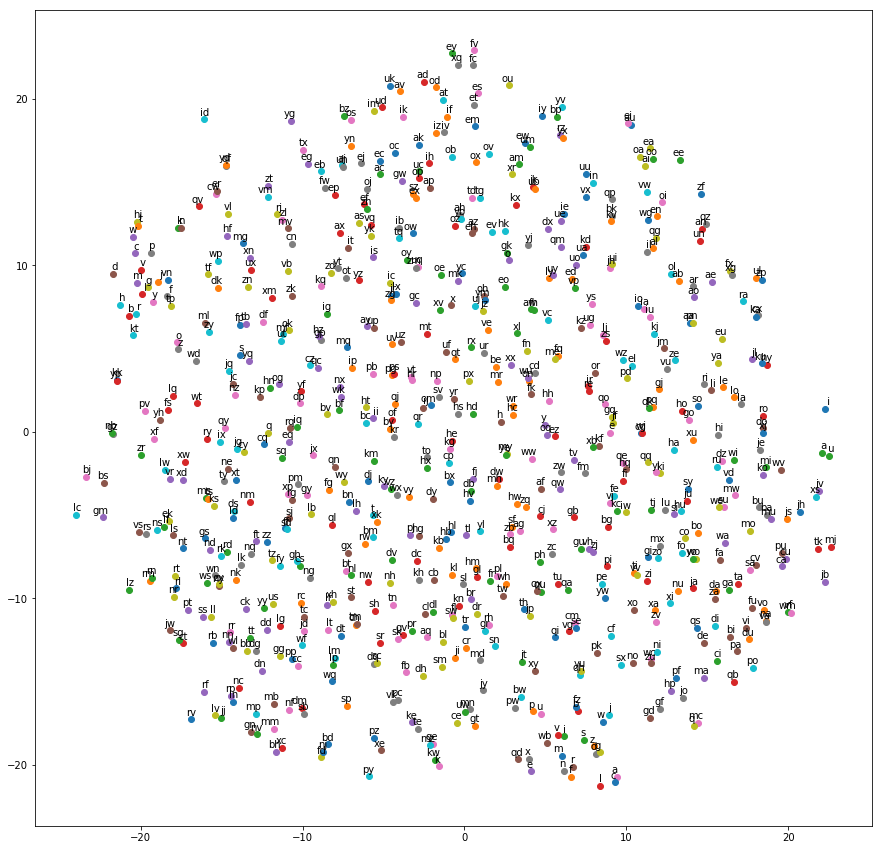

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(0, num_points)]
plot(two_d_embeddings, words)